## KLT TRACKING FOR MULTIPLE OBJECTS IN A GIVEN SCENE

1. SETTING UP VIDEO CAPTURE AND PREPROCESSING FRAMES

In [20]:
import cv2
import numpy as np

# Capture video from file or webcam (replace 'video.mp4' with your video file path)
cap = cv2.VideoCapture('traffic3.mp4')

# Parameters for ShiTomasi corner detection
feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

# Parameters for Lucas-Kanade optical flow (KLT)
lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Read the first frame
ret, old_frame = cap.read()
if not ret:
    print("Cannot read video file")
    cap.release()
    exit()

# Convert the first frame to grayscale
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)


2. LIST OF VIDEO FILES TO PROCESS


In [21]:

# List of video files to process
video_files = ['traffic4.mp4', 'traffic2.mp4', 'traffic3.mp4']

for video_file in video_files:
    print(f"Processing video: {video_file}")
    
    # Open the video file
    cap = cv2.VideoCapture(video_file)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_file}.")
        continue

    # Calculate train-test split
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    train_frames = int(total_frames * train_ratio)

    # Read the first frame for initial feature detection
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    ret, first_frame = cap.read()
    if not ret:
        print(f"Error: Could not read the first frame of {video_file}.")
        cap.release()
        continue

    # Convert the first frame to grayscale for feature detection
    first_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
    features = cv2.goodFeaturesToTrack(first_gray, mask=None, **feature_params)

    # Process frames for training segment
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    for i in range(train_frames):
        ret, frame = cap.read()
        if not ret:
            print(f"Reached end of training segment for {video_file}.")
            break

        # Insert tracking and feature update code here for training

    # Process frames for testing segment
    for i in range(train_frames, total_frames):
        ret, frame = cap.read()
        if not ret:
            print(f"Reached end of testing segment for {video_file}.")
            break

        # Insert tracking and feature update code here for testing

    cap.release()
    print(f"Completed processing video: {video_file}")

Processing video: traffic4.mp4
Completed processing video: traffic4.mp4
Processing video: traffic2.mp4
Completed processing video: traffic2.mp4
Processing video: traffic3.mp4
Completed processing video: traffic3.mp4


 3. TEST-TRAIN SPLIT

In [22]:

# Define train-test split ratio
train_ratio = 0.8

# Determine total frames in the video
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
train_frames = int(total_frames * train_ratio)

# Reset the video capture to the beginning
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)


False

4. DETECTING FEATURES IN INITIAL FRAME

In [23]:
import cv2
import numpy as np

# Parameters for ShiTomasi corner detection (good features to track)
feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

# Load the video
cap = cv2.VideoCapture('traffic2.mp4')

# Check if video opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Read the first frame
ret, frame = cap.read()
if not ret:
    print("Error: Could not read the video frame.")
    cap.release()
    exit()

# Convert frame to grayscale
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Detect features (key points) to track
features = cv2.goodFeaturesToTrack(gray, mask=None, **feature_params)

# Check if points are detected
if features is None:
    print("No features detected.")
    cap.release()
    exit()

# Draw the detected features as circles
for point in features:
    x, y = point.ravel()
    cv2.circle(frame, (int(x), int(y)), 5, (0, 0, 255), -1)  # Green circles for features

# Display the frame with features
cv2.imshow('Feature Detection', frame)

# Wait for key press and close window
cv2.waitKey(0)
cap.release()
cv2.destroyAllWindows()

5. DETECTING OBJECTS USING BACKGROUND SUBTRACTOR

In [24]:
import cv2
import numpy as np

# Load video
cap = cv2.VideoCapture("traffic2.mp4")  # Replace with your own video file

# Initialize background subtractor
bg_subtractor = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=50, detectShadows=True)

# Parameters for KLT Tracker
lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Initialize tracking points list
tracking_points = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Apply background subtraction to detect moving objects
    fg_mask = bg_subtractor.apply(frame)
    
    # Threshold the mask to binary
    _, fg_mask = cv2.threshold(fg_mask, 250, 255, cv2.THRESH_BINARY)

    # Find contours of moving objects
    contours, _ = cv2.findContours(fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on size to avoid noise
    bounding_boxes = []
    for cnt in contours:
        if cv2.contourArea(cnt) > 500:  # Filter out small contours
            x, y, w, h = cv2.boundingRect(cnt)
            bounding_boxes.append((x, y, w, h))
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw bounding box

            # Initialize tracking points at the center of each bounding box
            center = np.array([[x + w / 2, y + h / 2]], dtype=np.float32)
            tracking_points.append(center)

    cv2.imshow("Detection", frame)

    # Press 'q' to exit the loop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


6.TRACKING KEY POINTS ACROSS FRAMES

In [25]:
import cv2
import numpy as np

# Load video
cap = cv2.VideoCapture("traffic2.mp4")  # Replace with your own video file

# Check if video opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Parameters for optical flow
lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Initialize the first frame
ret, frame = cap.read()
if not ret:
    print("Error: Failed to read first frame.")
    exit()

# Convert to grayscale for optical flow
old_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Detect good features to track in the first frame
initial_points = cv2.goodFeaturesToTrack(old_gray, mask=None, **dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7))

# Initialize a mask for drawing the tracks
mask = np.zeros_like(frame)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert to grayscale for optical flow
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calculate optical flow to track points in the new frame
    new_points, status, _ = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, initial_points, None, **lk_params)

    # Select good points (points that were successfully tracked)
    good_new = new_points[status == 1]
    good_old = initial_points[status == 1]

    # Re-detect points if necessary (when many points are lost)
    if len(good_new) < 10:  # If fewer than 10 points are left, re-detect features
        initial_points = cv2.goodFeaturesToTrack(frame_gray, mask=None, **dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7))
        good_new = initial_points
        good_old = good_new

    # Draw tracking lines and points on the frame
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = int(new[0]), int(new[1])  # Convert to integers
        c, d = int(old[0]), int(old[1])  # Convert to integers
        mask = cv2.line(mask, (a, b), (c, d), (0, 255, 0), 2)  # Green line for tracking
        frame = cv2.circle(frame, (a, b), 5, (0, 0, 255), -1)  # Red circle for new points

    # Overlay the mask on the frame
    img = cv2.add(frame, mask)

    # Display the tracking result
    cv2.imshow("Tracking", img)

    # Update the previous frame and points
    old_gray = frame_gray.copy()
    initial_points = good_new.reshape(-1, 1, 2)

    # Exit on 'q' key
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()



6. CALCULATING ACCURACY

In [27]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Parameters for Shi-Tomasi corner detection
feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

# Parameters for Lucas-Kanade optical flow (KLT)
lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Initialize variables to store total and correct tracking points
total_points = 0
correctly_tracked = 0

# Threshold for tracking accuracy (in pixels)
accuracy_threshold = 5  # Define a pixel distance tolerance for accurate tracking

# Process video for accuracy measurement
cap = cv2.VideoCapture('traffic2.mp4')  # Replace with your video if different
ret, first_frame = cap.read()
if not ret:
    print("Error: Could not read the video frame.")
    cap.release()
    exit()

# Convert frame to grayscale for feature detection
gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)

# Detect initial features to track
features = cv2.goodFeaturesToTrack(gray, mask=None, **feature_params)
prev_gray = gray.copy()

# Track features through video frames
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to grayscale for tracking
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Use KLT tracker to track points
    new_features, status, _ = cv2.calcOpticalFlowPyrLK(prev_gray, gray, features, None, **lk_params)

    # Update tracking points based on status and accuracy threshold
    for i, st in enumerate(status):
        if st == 1:  # Only consider points that were successfully tracked
            total_points += 1
            # Check if the tracked point is within the accuracy threshold
            distance = np.linalg.norm(new_features[i] - features[i])
            if distance <= accuracy_threshold:
                correctly_tracked += 1

            # Draw tracked points
            x, y = new_features[i].ravel()
            cv2.circle(frame, (int(x), int(y)), 5, (0, 255, 0), -1)

    # Show tracking result for visualization
    cv2.imshow('Tracking', frame)

    # Break loop if 'q' is pressed
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

    # Update previous frame and points
    prev_gray = gray.copy()
    features = new_features[status == 1].reshape(-1, 1, 2)

# Calculate accuracy
accuracy = (correctly_tracked / total_points) * 100 if total_points > 0 else 0
print(f'Tracking Accuracy: {accuracy:.2f}%')

# Release video capture and close windows
cap.release()
cv2.destroyAllWindows()


Tracking Accuracy: 97.59%


7. VISUALIZING ACCURACY

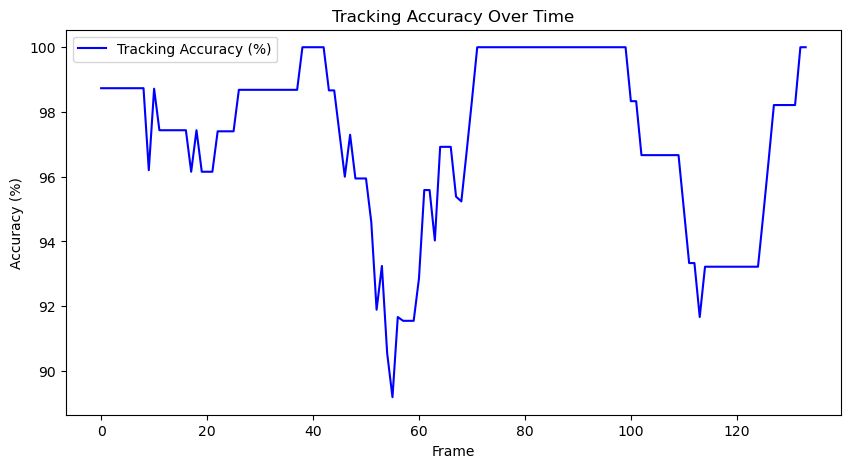

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Parameters for Shi-Tomasi corner detection
feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

# Parameters for Lucas-Kanade optical flow (KLT)
lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Initialize variables to store total and correct tracking points and frame-wise accuracy
total_points = 0
correctly_tracked = 0
frame_accuracies = []  # To store accuracy for each frame

# Threshold for tracking accuracy (in pixels)
accuracy_threshold = 5

# Process video for accuracy measurement
cap = cv2.VideoCapture('traffic2.mp4')  # Replace with your video if different
ret, first_frame = cap.read()
if not ret:
    print("Error: Could not read the video frame.")
    cap.release()
    exit()

# Convert frame to grayscale for feature detection
gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)

# Detect initial features to track
features = cv2.goodFeaturesToTrack(gray, mask=None, **feature_params)
prev_gray = gray.copy()

# Track features through video frames
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to grayscale for tracking
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Use KLT tracker to track points
    new_features, status, _ = cv2.calcOpticalFlowPyrLK(prev_gray, gray, features, None, **lk_params)

    # Frame-level accuracy tracking
    frame_total_points = 0
    frame_correctly_tracked = 0

    # Update tracking points based on status and accuracy threshold
    for i, st in enumerate(status):
        if st == 1:  # Only consider points that were successfully tracked
            frame_total_points += 1
            distance = np.linalg.norm(new_features[i] - features[i])
            if distance <= accuracy_threshold:
                frame_correctly_tracked += 1
                color = (0, 255, 0)  # Green for accurate
            else:
                color = (0, 0, 255)  # Red for inaccurate

            # Draw tracked points
            x, y = new_features[i].ravel()
            cv2.circle(frame, (int(x), int(y)), 5, color, -1)

    # Calculate frame accuracy and append to list
    if frame_total_points > 0:
        frame_accuracy = (frame_correctly_tracked / frame_total_points) * 100
        frame_accuracies.append(frame_accuracy)
    else:
        frame_accuracies.append(0)  # No points tracked, zero accuracy

    # Display tracking with color-coded accuracy
    cv2.imshow('Tracking Accuracy Visualization', frame)

    # Break loop if 'q' is pressed
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

    # Update previous frame and points
    prev_gray = gray.copy()
    features = new_features[status == 1].reshape(-1, 1, 2)

# Plot accuracy over time
plt.figure(figsize=(10, 5))
plt.plot(frame_accuracies, label="Tracking Accuracy (%)", color='blue')
plt.xlabel("Frame")
plt.ylabel("Accuracy (%)")
plt.title("Tracking Accuracy Over Time")
plt.legend()
plt.show()

# Release video capture and close windows
cap.release()
cv2.destroyAllWindows()

